In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans Mono'
from scipy.interpolate import interp1d
import itertools

class Preprocessor():
    def __init__(self, gap_max=1.0, seg_dur=5.0, ol_rate=0.5, resamp_freq=100, burn=0., ma=None):
        self.gap_max = gap_max
        self.seg_dur = seg_dur
        self.ol_rate = ol_rate
        self.resamp_freq = resamp_freq
        self.burn = burn
        self.ma = ma

    def clean(self, df):
        # df = pd.read_csv(
        #     f'../input/WISDM_ar_v1.1/WISDM_ar_v1.1_raw_modified.txt', 
        #     names=['user', 'activity', 'timestamp', 'ax', 'ay', 'az'],
        #     header=None)
        df = df.copy()
        df['timestamp'] *= 1e-9
        df = df[df['timestamp'] != 0]
        df = df[~df['timestamp'].duplicated()]
        df = df.dropna()
        df = df.reset_index(drop=True)
        return df

    def generate_components(self, df):
        gap_max = self.gap_max
        seg_dur = self.seg_dur
        ol_rate = self.ol_rate
        resamp_freq = self.resamp_freq

        users = sorted(df['user'].unique())
        activities = sorted(df['activity'].unique())

        for user, activity in itertools.product(users, activities):
            mask_ua = (df['user'] == user) & (df['activity'] == activity)
            if not mask_ua.any():
                continue
            cpnt_nums = np.cumsum( (df.loc[mask_ua, 'timestamp'].diff() > gap_max) | (df.loc[mask_ua, 'timestamp'].diff() < 0) )
            for num in range(cpnt_nums.min(), cpnt_nums.max()+1):
                cpnt = df[mask_ua][cpnt_nums == num]
                cpnt = cpnt[cpnt['timestamp'] >= (cpnt['timestamp'].min() + self.burn)]
                cpnt['timestamp'] -= cpnt['timestamp'].min()

                if len(cpnt) < 4:
                    continue
                # trusting timestamps
                f = interp1d(cpnt['timestamp'], cpnt[['ax', 'ay', 'az']], axis=0, kind='linear')
                t = np.arange(0, cpnt['timestamp'].max(), 1/resamp_freq)
                # not trusting timestamps
                # f = interp1d(np.arange(cpnt.shape[0])/20, cpnt[['ax', 'ay', 'az']], axis=0, kind='linear')
                # t = np.arange(5*cpnt.shape[0]-5)/100
                signal = f(t)

                if self.ma is not None:
                    signal = np.stack([np.convolve(el, np.ones((self.ma, ))/self.ma, mode='same') for el in signal.T], axis=-1)
                yield signal, activity, user

    def transform(self, df):
        gap_max = self.gap_max
        seg_dur = self.seg_dur
        ol_rate = self.ol_rate
        resamp_freq = self.resamp_freq

        df = self.clean(df)

        segments = []
        seg_usrs = []
        seg_acts = []

        for cpnt, act, usr in self.generate_components(df):
            for begin in np.arange(0, cpnt.shape[0]-int(seg_dur*resamp_freq), int(seg_dur*(1-ol_rate)*resamp_freq)):
                segments.append(cpnt[begin:begin+int(seg_dur*resamp_freq)])
                seg_acts.append(act)
                seg_usrs.append(usr)

        return np.array(segments), np.array(seg_acts), np.array(seg_usrs)


def load_dataset(gap_max=1.0, seg_dur=5.0, ol_rate=0.5, resamp_freq=100, burn=0., ma=None):
    return Preprocessor(
        gap_max=gap_max, seg_dur=seg_dur, ol_rate=ol_rate, resamp_freq=resamp_freq, burn=burn, ma=ma
    ).transform(df)

df = pd.read_csv(
    f'../input/WISDM_ar_v1.1/WISDM_ar_v1.1_raw_modified.txt', 
    names=['user', 'activity', 'timestamp', 'ax', 'ay', 'az'],
    header=None)

users = sorted(df['user'].unique())
activities = sorted(df['activity'].unique())

In [252]:
import itertools
from sklearn.preprocessing import OrdinalEncoder

# segs, seg_acts, seg_usrs = Preprocessor(seg_dur=1, ol_rate=0., ma=30).transform(df)
segs, seg_acts, seg_usrs = load_dataset(seg_dur=4, ol_rate=0.5, resamp_freq=100, ma=10)
seg_acts_encoded = OrdinalEncoder(categories=[activities]).fit_transform(seg_acts[..., np.newaxis])[:, 0]

usrwise_count = []
usrwise_rel_count = []
for user, act in itertools.product(users, activities):
    mask_usr_act = (seg_usrs == user) & (seg_acts == act)
    if np.any(mask_usr_act):
        usrwise_count.append( np.cumsum(mask_usr_act)*mask_usr_act)
        usrwise_rel_count.append( np.cumsum(mask_usr_act)*mask_usr_act/np.sum(mask_usr_act) )
usrwise_count = np.sum(usrwise_count, axis=0)
usrwise_rel_count = np.sum(usrwise_rel_count, axis=0)

In [253]:
from tools import Embedder, Weighting, SineFilter, calculate_weighting_vectors

lag = 8
reduce = 0
dim_raw = 2

embedder = Embedder(lag=lag, reduce=reduce, dim_raw=dim_raw, channel_last=True)
x = embedder.transform(segs)
w = calculate_weighting_vectors(x)[..., np.newaxis]

dx = np.diff(x, axis=-2)
w_dx = calculate_weighting_vectors(dx)[..., np.newaxis]

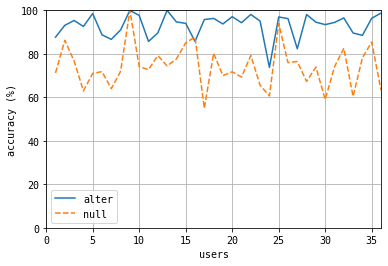

In [12]:
%matplotlib inline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

sine_filter = SineFilter(dim=x.shape[-1], n_filters=64, scale=1, random_state=42)

features = sine_filter.apply(x, w)
F_0 = sine_filter.apply(x, np.ones_like(w))
# F_1 = np.concatenate([F_1, sine_filter.apply(x_demean, w)], axis=-1)

mask_train = usrwise_rel_count < 0.8  # fully temporal
mask_train = (usrwise_count % 5) < 4  # fully non-temporal
# mask_train_1s = (usrwise_rel_count_1s < 0.4) | ((usrwise_rel_count_1s > 0.5) & (usrwise_rel_count_1s < 0.9))
# mask_train_1s = (usrwise_rel_count_1s > 0.2)
mask_test = ~mask_train

model = make_pipeline(
    PCA(
        n_components=5
    ),
    SVC(
        # probability=True,
        gamma=1e-3,
        random_state=42
    )
)
# model = SGDClassifier(
#     loss='log',
#     random_state=42
# )
scores = np.zeros((2, len(users)))
for user in users:
    if user == 9:
        scores[:, user-1] = 1.
        continue
    mask_usr = seg_usrs == user

    model.fit(features[mask_usr & mask_train], seg_acts[mask_usr & mask_train])
    scores[0, user-1] = (
        accuracy_score(seg_acts[mask_usr & mask_test], model.predict(features[mask_usr & mask_test]))
    )

    model.fit(F_0[mask_usr & mask_train], seg_acts[mask_usr & mask_train])
    scores[1, user-1] = (
        accuracy_score(seg_acts[mask_usr & mask_test], model.predict(F_0[mask_usr & mask_test]))
    )

plt.plot(users, scores[0]*1e2, label='alter')
plt.plot(users, scores[1]*1e2, linestyle='--', label='null')
plt.legend()
plt.grid(); plt.xlabel('users'); plt.xlim(0, 36); plt.ylabel('accuracy (%)'); plt.ylim(0, 100)
plt.show(); plt.close()

In [260]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor
from sklearn.metrics import recall_score, precision_score, f1_score
from scipy.spatial import distance_matrix
from scipy.signal import cwt, ricker
from scipy.signal import convolve
import networkx as nx


# means = np.mean(segs, axis=-2)
means_w = np.sum(x*w, axis=-2) / np.sum(w, axis=-2)
stds_w = np.linalg.norm((x - means_w[..., np.newaxis, :])*w, axis=-2) / np.power(np.sum(w, axis=-2), 1/2)
skews_w = np.linalg.norm((x - means_w[..., np.newaxis, :])*w, ord=3, axis=-2) / np.power(np.sum(w, axis=-2), 1/3)
kurts_w = np.linalg.norm((x - means_w[..., np.newaxis, :])*w, ord=4, axis=-2) / np.power(np.sum(w, axis=-2), 1/4)

means_d_w = np.sum(dx*w_dx, axis=-2) / np.sum(w_dx, axis=-2)
stds_d_w = np.linalg.norm((dx - means_d_w[..., np.newaxis, :])*w_dx, axis=-2) / np.power(np.sum(w_dx, axis=-2), 1/2)
skews_d_w = np.linalg.norm((dx - means_d_w[..., np.newaxis, :])*w_dx, ord=3, axis=-2) / np.power(np.sum(w_dx, axis=-2), 1/3)
kurts_d_w = np.linalg.norm((dx - means_d_w[..., np.newaxis, :])*w_dx, ord=4, axis=-2) / np.power(np.sum(w_dx, axis=-2), 1/4)

dx_abs = np.linalg.norm(dx, axis=-1, keepdims=True)
means_d_abs_w = np.sum(dx_abs*w_dx, axis=-2) / np.sum(w_dx, axis=-2)
stds_d_abs_w = np.linalg.norm((dx_abs - means_d_abs_w[..., np.newaxis, :])*w_dx, axis=-2) / np.power(np.sum(w_dx, axis=-2), 1/2)
skews_d_abs_w = np.linalg.norm((dx_abs - means_d_abs_w[..., np.newaxis, :])*w_dx, ord=3, axis=-2) / np.power(np.sum(w_dx, axis=-2), 1/3)
kurts_d_abs_w = np.linalg.norm((dx_abs - means_d_abs_w[..., np.newaxis, :])*w_dx, ord=4, axis=-2) / np.power(np.sum(w_dx, axis=-2), 1/4)

fft_feature = np.abs( np.fft.rfft(segs, axis=-2)[:, 1:500, :].reshape(x.shape[0], -1) )
fft_feature_w = np.abs( np.fft.rfft(x*w, axis=-2)[:, 1:500, :].reshape(x.shape[0], -1) )

# cwt_fft_w = np.abs( np.fft.rfft(
#     convolve(x*w, ricker(11, 1.).reshape(1, -1, 1), mode='full')
# )[:, 1:500, :].reshape(x.shape[0], -1))

sine_filter = SineFilter(dim=x.shape[-1], n_filters=16, scale=1e-1, random_state=42)
sine_0d = sine_filter.apply(x, w)  #new filter......

w_mid = (w[:, 1:] + w[:, :-1])/2
midpts = (x[:, 1:] + x[:, :-1])/2
disps = np.diff(x, axis=-2)
filters = [
    SineFilter(dim=x.shape[-1], n_filters=16, scale=1e-1, random_state=42)
    for _ in range(x.shape[-1])
]
sine_1d = np.zeros((x.shape[0], 16))
for i, sf in enumerate(filters):
    sine_1d += sf.apply(midpts, w_mid*disps[..., i, np.newaxis])

sine_filter_dx = SineFilter(dim=x.shape[-1], n_filters=16, scale=1e-1, random_state=42)
sine_dx = sine_filter_dx.apply(dx, w_dx)

###
# x_small = x.reshape(-1, x.shape[-1])[::973]
# nn_learner = NearestNeighbors().fit(x_small)
# adj = nn_learner.kneighbors_graph(x_small).todense()
# adj[np.arange(adj.shape[0]), np.arange(adj.shape[0])] = 0
# np.reciprocal(
#     distance_matrix(x_small, x_small),
#     out=adj,
#     where=adj>0
# )
# graph = nx.from_numpy_array(adj)
# lap = nx.laplacian_matrix(graph).todense()
# eig_vals, eig_vecs = np.linalg.eigh(lap)
# eig_vecs = np.array(eig_vecs)

# n_components = nx.number_connected_components(graph)
# knn_reg = KNeighborsRegressor()
##
# knn_reg.fit(x_small, eig_vecs[:, n_components:n_components+500])
# knn_features = np.sum(knn_reg.predict(x.reshape(-1, x.shape[-1])).reshape(x.shape[:-1]+(-1,))*w, axis=-2)

features = np.concatenate([
    means_w, stds_w, skews_w, kurts_w,
    means_d_w, stds_d_w, skews_d_w, kurts_d_w,
    means_d_abs_w, stds_d_abs_w, skews_d_abs_w, kurts_d_abs_w,
    fft_feature,
    fft_feature_w,
    sine_0d,
    sine_1d,
    sine_dx,
    # knn_features
], axis=-1)



from lightgbm import LGBMClassifier

# partial_clss =  [2, 3]
partial_clss = [0, 1, 2, 3, 4, 5]
mask_partial = np.isin(seg_acts_encoded, partial_clss )
features = features[mask_partial]

y_true = seg_acts_encoded[mask_partial]
y_pred = y_true.copy()

rng = np.random.default_rng(42)
n_fold = 5
# fold_assign = rng.integers(0, 5, x.shape[:1])
fold_assign = rng.permuted(np.linspace(0, n_fold, endpoint=False)//1)
for fold_no in range(n_fold):
    # usrs_test = rng.choice(users, 6, replace=False)

    mask_test = fold_assign == fold_no
    mask_train = ~mask_test

    # mask_train &= mask_partial
    # mask_test &= mask_partial

    model = make_pipeline(
        # PowerTransformer(),
        # UMAP(
        #     n_components=10,
        #     random_state=42
        # ),
        # PCA(
        #     n_components=5,
        #     whiten=True,
        #     random_state=42
        # ),
        # MLPClassifier(
        #     hidden_layer_sizes=(50, 20, ),
        #     max_iter=1000,
        #     random_state=42,
        # ),
        # KNeighborsClassifier(
        #     n_neighbors=10,
        # ),
        LGBMClassifier(random_state=42)
        # SVC(
        #     gamma=1e-2,
        #     random_state=42
        # )
    )
    model.fit(features[mask_train], y_true[mask_train])

    y_pred[mask_test] = model.predict(features[mask_test])

# print(accuracy_score(seg_acts_encoded[mask_train], model.predict(F_1[mask_train]))*1e2)
print(accuracy_score(y_true, y_pred)*1e2)
print(confusion_matrix(y_true, y_pred))
print(activities)

In [246]:
recall_score(y_true, y_pred, average=None)

array([0.73114754, 0.93322361, 0.9076087 , 0.93739425, 0.68406961,
       0.89322421])

In [259]:
import tensorflow as tf
from tensorflow import keras
import random

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

model = keras.Sequential([
    keras.layers.LSTM(
        units=32,
        return_sequences=True,
    ),
    keras.layers.LSTM(
        units=32,
        return_sequences=True,
    ),
    keras.layers.Conv1D(
        filters=64,
        kernel_size=5,
        strides=2,
        padding='same',
        activation='relu',
        kernel_regularizer='l2'
    ),
    keras.layers.MaxPooling1D(
        pool_size=2,
        strides=2,
    ),
    keras.layers.Conv1D(
        filters=128,
        kernel_size=3,
        strides=1,
        padding='same',
        activation='relu',
        kernel_regularizer='l2'
    ),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(
        units=6,
        activation='softmax',
        kernel_regularizer='l2'
    )
])

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


segs_dnn, seg_acts_dnn, seg_usrs_dnn = load_dataset(seg_dur=6, ol_rate=0.5, resamp_freq=20, ma=None)
seg_acts_encoded_dnn = OrdinalEncoder(categories=[activities]).fit_transform(seg_acts_dnn[..., np.newaxis])[:, 0]

rng = np.random.default_rng(42)
mask_train_dnn = ~np.isin(seg_usrs_dnn, rng.choice(np.unique(seg_usrs_dnn), 6, replace=False))
mask_test_dnn = ~mask_train_dnn

model.fit(
    segs_dnn[mask_train_dnn], seg_acts_encoded_dnn[mask_train_dnn],
    epochs=200,
    validation_data=(segs_dnn[mask_test_dnn], seg_acts_encoded_dnn[mask_test_dnn])
)
np.mean(np.argmax(model.predict(segs_dnn[mask_test_dnn]), axis=-1) == seg_acts_encoded_dnn[mask_test_dnn])*1e2

Epoch 1/200
472/472 [==============================] - 24s 42ms/step - loss: 1.1837 - accuracy: 0.8183 - val_loss: 1.7229 - val_accuracy: 0.4680
Epoch 2/200
472/472 [==============================] - 19s 41ms/step - loss: 0.4679 - accuracy: 0.9015 - val_loss: 1.0537 - val_accuracy: 0.7105
Epoch 3/200
472/472 [==============================] - 19s 40ms/step - loss: 0.3003 - accuracy: 0.9268 - val_loss: 0.8754 - val_accuracy: 0.8127
Epoch 4/200
472/472 [==============================] - 19s 40ms/step - loss: 0.2426 - accuracy: 0.9368 - val_loss: 1.0004 - val_accuracy: 0.7815
Epoch 5/200
472/472 [==============================] - 19s 40ms/step - loss: 0.2033 - accuracy: 0.9502 - val_loss: 0.7928 - val_accuracy: 0.8288
Epoch 6/200
472/472 [==============================] - 19s 40ms/step - loss: 0.1706 - accuracy: 0.9588 - val_loss: 1.0931 - val_accuracy: 0.7700
Epoch 7/200
472/472 [==============================] - 19s 40ms/step - loss: 0.1531 - accuracy: 0.9644 - val_loss: 1.1118 - val_ac

85.88863463005339

In [70]:
%matplotlib qt
from umap import UMAP

reducer = UMAP(n_components=3, random_state=42)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for num, l in enumerate(['Sitting', 'Standing']):
    ax.scatter(*reducer.fit_transform(features)[y_true==l].T, s=10., c=f'C{num}')
plt.show()

In [44]:
%matplotlib qt
sit_mean = np.mean(segs[seg_acts == 'Sitting'], axis=-2)
stand_mean = np.mean(segs[seg_acts == 'Standing'], axis=-2)
means = np.concatenate([sit_mean, stand_mean], axis=0)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*sit_mean.T, s=10, color='C0')
ax.scatter(*stand_mean.T, s=10, color='C1')
plt.show()

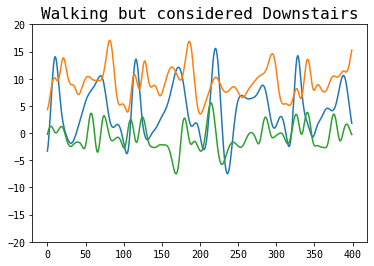

In [28]:
%matplotlib inline
mask_err = (y_pred != y_true)
lt = 5
lp = 0
mask_err = (y_true == lt) & (y_pred == lp)

plt.plot(segs[mask_test][mask_err][0])
plt.title(f'{activities[lt]} but considered {activities[lp]}', fontsize=16)
plt.ylim(-20, 20)
plt.show(); plt.close()

In [161]:
pos = nx.spring_layout(graph)

In [169]:
nx.draw_networkx(
    graph, pos=pos, with_labels=False, node_size=10,
    node_color=eig_vecs[40],
    cmap='plasma'
)

In [654]:
label = labels[5]

sers = seg_1s_ma30[mask_usr & mask_train & (seg_acts == label)]
for i in range(sers.shape[0]):
    ser = sers[i]
    plt.plot(ser[..., 0], color='C0', alpha=0.5)
    plt.plot(ser[..., 1], color='C1', alpha=0.5)
    plt.plot(ser[..., 2], color='C2', alpha=0.5)
    if (i+1)% 20 == 0:
        plt.title(label)
        plt.ylim(-1.5, 1.5)
        plt.show(); plt.close()
print('aaaaa')
sers = seg_1s_ma30[mask_usr & mask_test & (seg_acts == label)]
for j in range(sers.shape[0]):
    ser = sers[j]
    plt.plot(ser[..., 0], color='C0', alpha=0.5)
    plt.plot(ser[..., 1], color='C1', alpha=0.5)
    plt.plot(ser[..., 2], color='C2', alpha=0.5)
    if (j+1)% 20 == 0:
        plt.title(label)
        plt.ylim(-1.5, 1.5)
        plt.show(); plt.close()
    

IndexError: list index out of range

In [19]:
from umap import UMAP
mask = seg_usrs == 3
reducer = UMAP(random_state=42)
reduced = reducer.fit_transform(features[mask])

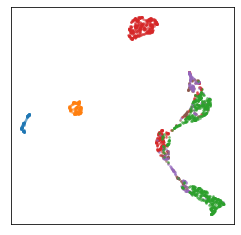

In [20]:
plt.figure(figsize=(4, 4))
for i in range(6):
    c = [2, 3, 5, 1, 4, 0].index(i)
    # Sitting, Standing, Walking, Jogging ,Upstairs, Downstairs
    plt.scatter(
        *reduced[seg_acts[mask] == activities[i]].T, 
        c=f'C{c}',
        s=3., 
        alpha=.5,
        label=activities[i]
    )
# plt.legend()
plt.xticks([]); plt.yticks([])
plt.show(); plt.close()

In [ ]:
df.groupby(['user', 'activity'])[['timestamp']].agg('count').reset_index().pivot(index='user', columns='activity').fillna(0)

timestamp                                             
activity Downstairs  Jogging  Sitting Standing Upstairs  Walking
user                                                            
1            2909.0  10871.0      0.0      0.0   3095.0  12759.0
2               0.0  11662.0      0.0      0.0      0.0  11647.0
3            3260.0  10845.0   1534.0   2721.0   3357.0  12795.0
4            1681.0    778.0   1158.0      0.0   1311.0   5424.0
5            3117.0   6173.0   1558.0   1463.0   2971.0  11679.0
6            1401.0   9386.0   1568.0    698.0   1636.0  11740.0
7            2210.0   8928.0   2456.0   2329.0   3545.0  10776.0
8            3243.0   9972.0   2573.0   3203.0   4357.0  16759.0
9               0.0      0.0      0.0      0.0      0.0  12801.0
10           3745.0  11924.0      0.0   1610.0   4231.0  12816.0
11           2070.0  12327.0      0.0      0.0   3820.0  11089.0
12           2734.0  12049.0   2140.0   1642.0   2510.0  10600.0
13           4127.0   9541.0   1030.0   1527.0   4526.0  12579.0
14           2842.0  13059.0      0.0      0.0   8098.0  13683.0
15           1666.0   8172.0      0.0      0.0   1886.0  10386.0
16           1359.0      0.0   2658.0   1875.0   1148.0  10806.0
17           3720.0   2887.0      0.0      0.0   5612.0   9603.0
18           2355.0   9157.0   1369.0   1826.0   2313.0  12335.0
19           2561.0   9617.0   2431.0   2095.0   4221.0  11606.0
20           4551.0   8443.0  15126.0   5266.0   4433.0  12106.0
21           3912.0   9364.0   1504.0   2768.0   4723.0  12239.0
22           3074.0   4769.0      0.0      0.0   4405.0   5806.0
23           1755.0  10738.0      0.0      0.0   4414.0   5683.0
24           2876.0  12124.0    669.0    533.0   2987.0   6191.0
25              0.0   6442.0      0.0      0.0      0.0   6884.0
26           3668.0  10843.0      0.0      0.0   3355.0  12415.0
27           3318.0   9262.0   2044.0   1608.0   2784.0  11602.0
28           2856.0      0.0      0.0   1253.0   2802.0  13399.0
29           4100.0   9485.0   2105.0   1409.0   4663.0  11968.0
30           3231.0      0.0   1242.0   2831.0   3564.0   9828.0
31           3817.0  13912.0   2046.0   2576.0   4605.0  16674.0
32           1938.0   7541.0   2802.0   1540.0   3595.0  12218.0
33           4493.0   2946.0   2907.0   1362.0   2214.0  14693.0
34           2627.0  10896.0   1256.0   1020.0   3549.0  10139.0
35              0.0  10761.0   1533.0   1012.0      0.0   6760.0
36           4118.0  11246.0   2328.0   1865.0   5308.0   6122.0

In [ ]:
# file_r = open(f'{_input_path}/WISDM_ar_v1.1_raw.txt', 'r')
# file_w = open(f'{_input_path}/WISDM_ar_v1.1_raw_modified.txt', 'w')
# for num, line in enumerate(file_r.readlines()):
#     if ',' not in line:
#         continue
#     line = line.replace(',;', ';').replace(';', '\n').replace('\n\n', '\n')
#     file_w.write(line)
# file_r.close()
# file_w.close()

In [230]:
# import itertools

# interval = 10
# for user, activity in itertools.product(sorted(df['user'].unique()), sorted(df['activity'].unique())):
#     mask = (df['user'] == user) & (df['activity'] == activity)
#     if not mask.any():
#         continue
#     time = df.loc[mask, 'timestamp']
#     m, M = time.min(), time.max()
#     for i in range( int((M-m)/5)+1 ):
#         t_lb, t_ub = m+interval*i, m+interval*(i+1)

#         mask_tmp = mask & (df['timestamp'] >= t_lb) & (df['timestamp'] <= t_ub)
#         if not mask_tmp.any():
#             continue
#         fig, axs = plt.subplots(nrows=3, figsize=(16, 9))
#         for j, ax in enumerate(axs):
#             ax.plot(df.loc[mask_tmp, 'timestamp'], df.loc[mask_tmp].iloc[:, 3+j])
#             ax.scatter(df.loc[mask_tmp, 'timestamp'], df.loc[mask_tmp].iloc[:, 3+j], s=16.)
#             ax.set_xlim(t_lb, t_ub); ax.set_ylim(-21, 21)
#             ax.grid()
#         title = f'User {user:0>2} {activity} - #{i+1:0>3}'
#         fig.suptitle(title, fontsize=20)
#         # plt.show() 
#         plt.savefig(f'../output/fragments/{title}.jpg')
#         plt.close()